In [1]:
#meta 1/10/2024 NLP for UDS demo. Part 1. Data Prep
# Text Analytics. Trends and topic modeling for UDS
#      Data: How did you...
#      Task: Explore data before modeling

#      input: myData/howdidu_tidy.csv
#      output: no persisted artifacts; analysis of how to vectorize
      

#started from nlp_2_model.ipynb 
#need to explore data before deciding how to prep data for ML


#history
#1/10/2024 EXPLORE DATA PREP
#      Ensure accurate counts between diff ways to handle text
#      Look for best way to vectorize
#      Explore clean data issues

#2/10/2004 META: MOVE TO MAC
#      local: get csv from ~2023-12-31


#Pipeline: nlp_0_data -> nlp_1_dataprep (here) -> nlp_2_model 

#$config $manual

In [2]:
import sys
import os
import pandas as pd
pd.set_option('display.max_colwidth', 50)
import numpy as np
#import matplotlib.pyplot as plt
#%matplotlib inline

import csv
#from joblib import load, dump


In [3]:
# dataprep - tokenization
from sklearn.feature_extraction import text
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer #transformer to tokenize dataset, aka bag-of-words activity
from sklearn.feature_extraction.text import TfidfVectorizer #rescale features by how informative they are

# Import the wordcloud library
from wordcloud import WordCloud

In [4]:
print(sys.version)
np.__version__, pd.__version__

3.10.10 (main, Jan 17 2024, 01:36:04) [Clang 12.0.5 (clang-1205.0.22.11)]


('1.26.3', '2.1.4')

In [5]:
#----- GlOBAL VARS -----
#data
DATA_DIR = 'myData'
DATA_FILE_IN = DATA_DIR + '/howdidu_tidy.csv' #$config

#IF
FLAG_SUBSET = False #$config for initial confirming smaller counts

# NLP: Text Analytics 
Data preparation for Text Analytics 

## 0. Load Tidy Data
from Pipeline prev: nlp_0_data

In [6]:
df_tidy = pd.read_csv(DATA_FILE_IN)

if FLAG_SUBSET:
    df_tidy = df_tidy[:20].copy() #$temp

print(df_tidy.shape)
print(df_tidy.columns)
df_tidy.head();

(326, 7)
Index(['Unnamed: 0', 'LGL Constituent ID', 'First Name', 'Last Name',
       'Contact rpt. description', 'Contact rpt. type',
       'contact_report_desc_short'],
      dtype='object')


In [7]:
pd.set_option('display.max_colwidth', None)
df_tidy[df_tidy['Contact rpt. description'].str.contains('Passcode')]; #other strings: '12532050468', '\'', '\$', 'donat'

In [8]:
# pd.set_option('display.max_colwidth', None)
# df_tidy[df_tidy['Contact rpt. description'].str.contains('How did you hear about')]

## 1. Prep Data for ML
Use `Contact rpt. description` for training

In [9]:
pd.set_option('display.max_colwidth', 50)

#feature engineering - concatentate text columns? here, no
df_tidy['all_text'] = df_tidy['Contact rpt. description'].str.replace('\s',' ', regex=True) #\s stands for “whitespace character”. In all flavors, it includes [ \t\r\n\f]
df_tidy['all_text'] = df_tidy['all_text'].str.lower()
#$manual rules
df_tidy['all_text'] = df_tidy['all_text'].str.replace('[\’\']s\s',' ', regex=True)
df_tidy['all_text'] = df_tidy['all_text'].str.replace('i[\’\']m\s','im ', regex=True)
df_tidy['all_text'] = df_tidy['all_text'].str.replace('y[\’\']all','you all', regex=True)
df_tidy['all_text'] = df_tidy['all_text'].str.replace('n/a','__na__') #replace n/a

print(df_tidy.shape)
df_tidy.tail();

(326, 8)


### 1.1 Prepare for Text Analytics 

Assemble Data into ML Expected Format.  
Scikit-learn expects a Numpy array-like structure. Transform to a structure acceptable by algorithm: 
- input features X(matrix) aka `train set`  
- target variable y(vector) 

Here:  
- X - column 'all_text'  = `train set`  
- y - n/a

In [10]:
#interested in words in all rows, column 0
text_train = df_tidy['all_text'] #.iloc[:,0]
text_train.shape

(326,)

In [11]:
text_train

0      carl met ivan at the uds meeting in bellevue a...
1                                         online  __na__
2                               community event   __na__
3                        sent email with greetings dec26
4                                        friend   __na__
                             ...                        
321                                 13sept22 carl texted
322                                 13sept22 carl texted
323                                 13sept22 carl texted
324                                 13sept22 carl texted
325                                 13sept22 carl texted
Name: all_text, Length: 326, dtype: object

### 1.2 Verify Text and Counts
by comparing with `Collections.Counter` and `CountVectorizer`

In [12]:
# Join 
long_string = ' '.join(list(text_train)) #keep case
len(long_string), long_string[:20]

(25950, 'carl met ivan at the')

In [13]:
long_string;

### 1.2a `Counter()`
dict subclass for counting hashable objects

In [14]:
import re
# split on white-space: good but has problems with extra punctuation
# l_long_string = re.split('[,\s\.]+', long_string) #list
# long_string_tidy = ' '.join(l_long_string)

#split words followed by space only: good but has problems with missing numbers
# long_string_tidy = re.sub("[^\w ]", "", long_string)

#split [words / numbers / _] followed by space
long_string_tidy = re.sub("[^a-zA-Z0-9_\$]", " ", long_string)

long_string_tidy;

In [15]:
# count word frequency & sort 
tokens = long_string_tidy.lower().split()
cc_word_counter = Counter(tokens) #class collections.Counter

#preview
print("cc_word_counter: ", len(cc_word_counter))
print("View cc_word_counter: ", cc_word_counter)
# list unique elements
#list(cc_word_counter)

cc_word_counter:  1026
View cc_word_counter:  Counter({'to': 157, 'and': 118, '__na__': 96, 'you': 96, 'ukraine': 91, 'the': 85, 'in': 81, 'a': 77, 'about': 74, 'defense': 69, 'support': 68, 'did': 67, 'hear': 61, 'how': 58, 'at': 57, 'for': 45, 'with': 44, 'he': 40, 'of': 40, 'meeting': 38, 'friend': 31, 'our': 31, 'by': 31, 'an': 30, 'i': 30, 'texted': 30, 'carl': 29, 'event': 29, 'on': 29, 'from': 29, 'us': 27, 'is': 26, 'are': 26, 'she': 25, 'other': 24, 'help': 22, 'email': 22, 'this': 22, 'her': 21, '__no_comment__': 21, 'text': 19, 'we': 19, 'has': 18, 'have': 18, 'came': 17, 'emailed': 17, 'newsletter': 16, 'phone': 16, 'referred': 16, 'that': 15, 'be': 15, 'contact': 15, 'your': 14, 'him': 14, 'not': 14, 'was': 14, 'no': 13, 'today': 12, 'european': 12, 'foods': 12, 'ukrainian': 12, 'way': 12, 'seattle': 12, 'bellevue': 11, 'zoom': 11, 'festival': 11, 'will': 11, 'reply': 11, 'larson': 10, 'group': 10, 'skyfest': 10, 'met': 9, 'uds': 9, 'sent': 9, 'out': 9, 'they': 9, 'https':

In [16]:
#confirm counts
#  w/o Counter, acting like it's a dict datastruct
print("Unique tokens: {}, Total count: {}".format(len(cc_word_counter),cc_word_counter.total()))
#  w Counter, seems convoluted
print("Unique tokens: {}, Total count: {}".format(Counter(cc_word_counter.values()).total(), Counter(dict(cc_word_counter)).total()))


Unique tokens: 1026, Total count: 4351
Unique tokens: 1026, Total count: 4351


In [17]:
#confirm counts w/ N most common
N_MOST = 10
cc_word_counter_10 = cc_word_counter.most_common(N_MOST) #class list
print(cc_word_counter_10)
print("\n")

print("Unique tokens: {}, Total count: {}".format(len(cc_word_counter_10), sum(dict(cc_word_counter_10).values())))
print("Unique tokens: {}, Total count: {}".format(Counter(cc_word_counter_10).total(), Counter(dict(cc_word_counter_10)).total()))

[('to', 157), ('and', 118), ('__na__', 96), ('you', 96), ('ukraine', 91), ('the', 85), ('in', 81), ('a', 77), ('about', 74), ('defense', 69)]


Unique tokens: 10, Total count: 944
Unique tokens: 10, Total count: 944


In [18]:
#N least common
cc_word_counter.most_common()[:-N_MOST-1:-1]

[('attendance', 1),
 ('type', 1),
 ('notice', 1),
 ('getting', 1),
 ('replied', 1),
 ('qrf', 1),
 ('uaw', 1),
 ('notifying', 1),
 ('artur', 1),
 ('vm', 1)]

### 1.2b `CountVectorizer()`
Convert a long string to a matrix of token counts

In [19]:
cv =  CountVectorizer(token_pattern='[a-zA-Z0-9_\$]+') #$config lcase lowercase=True, 
# 1) tokenize train data and build the vocabulary + 2)`transform` converts text to a bow representation: SciPy sparse matrix only stores non-zero entries
cv_fit = cv.fit_transform(text_train) #class scipy.sparse._csr.csr_matrix
cv_vocab = cv.get_feature_names_out() #class numpy.ndarray
print("Vocab: ", len(cv_vocab))
print("Preview vocab: ", cv_vocab[:10])

cv_fit.toarray().shape


Vocab:  1026
Preview vocab:  ['$100' '$605' '1' '10' '11' '12345' '12532050468' '13' '13520' '13sept22']


(326, 1026)

In [20]:
#lookup token
cv_count_list = cv_fit.toarray().sum(axis=0)

d_all = dict(zip(cv_vocab,cv_count_list))

token = 'Carl'
try:
    this_token = token
    this_count = d_all[this_token]
except KeyError:
    this_token = token.lower()
    this_count = d_all[this_token]
finally:
    print(this_token, this_count)

carl 29


In [21]:
cv_vocab, cv_count_list, cv_count_list.sum()

(array(['$100', '$605', '1', ..., 'zkk1cg5nd01osm5bs0l3sfzac1bkqt09',
        'zoom', 'zsu'], dtype=object),
 array([ 1,  1,  2, ...,  1, 11,  1]),
 4351)

In [22]:
assert sum(cc_word_counter.values()) == cv_count_list.sum()

### 1.2c `TfidfVectorizer()`

Convert a collection of raw documents to a matrix of TF-IDF features  
Equivalent to `CountVectorizer` followed by `TfidfTransformer`

In [23]:
tfidf_v = TfidfVectorizer(token_pattern='[a-zA-Z0-9_\$]+')#$config lcase lowercase=True, 
# 1) tokenize train data and build the vocabulary + 2)`transform` converts text to a bow representation: SciPy sparse matrix only stores non-zero entries
tfidf_v_fit = tfidf_v.fit_transform(text_train) #class scipy.sparse._csr.csr_matrix
tfidf_v_vocab = tfidf_v.get_feature_names_out() #class numpy.ndarray
print("Vocab: ", len(tfidf_v_vocab))
print("Preview vocab: ", tfidf_v_vocab[:10])

tfidf_v_fit.toarray().shape

Vocab:  1026
Preview vocab:  ['$100' '$605' '1' '10' '11' '12345' '12532050468' '13' '13520' '13sept22']


(326, 1026)

In [24]:
tfidf_v_count_list = tfidf_v_fit.toarray().sum(axis=0)
tfidf_v_vocab, tfidf_v_count_list, tfidf_v_count_list.sum()

(array(['$100', '$605', '1', ..., 'zkk1cg5nd01osm5bs0l3sfzac1bkqt09',
        'zoom', 'zsu'], dtype=object),
 array([0.04556395, 0.21725943, 0.14498051, ..., 0.04556395, 1.2099484 ,
        0.04556395]),
 861.1010693412521)

### 1.2.1 Diff between CC, CV and TfidfV vocabs
eventually get to the point of no diff

In [25]:
#diff
#list(cc_word_counter), cv_vocab.tolist()

np.setdiff1d(list(cc_word_counter), cv_vocab.tolist()), np.setdiff1d(cv_vocab.tolist(), list(cc_word_counter)), np.setdiff1d(tfidf_v_vocab.tolist(), list(cc_word_counter))

(array([], dtype='<U32'), array([], dtype='<U32'), array([], dtype='<U32'))

In [26]:
#save 3 vocabs
try:
    with open('myData/my_cc_vocab.csv', 'w', newline='', encoding='UTF-8') as myfile:
        wr = csv.writer(myfile, delimiter = '|')
        wr.writerows([r] for r in cc_word_counter)
except:
    print("An error occurred")
    for e in sys.exc_info():
        print("Error details: {}".format(str(e)))
        
try:
    with open('myData/my_cv_vocab.csv', 'w', newline='', encoding='UTF-8') as myfile:
        wr = csv.writer(myfile, delimiter = '|')
        wr.writerows([r] for r in cv_vocab)
except:
    print("An error occurred")
    for e in sys.exc_info():
        print("Error details: {}".format(str(e)))

try:
    with open('myData/my_tfidf_v_vocab.csv', 'w', newline='', encoding='UTF-8') as myfile:
        wr = csv.writer(myfile, delimiter = '|')
        wr.writerows([r] for r in tfidf_v_vocab)
except:
    print("An error occurred")
    for e in sys.exc_info():
        print("Error details: {}".format(str(e)))


- EDA - w/ WordCloud
src https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0

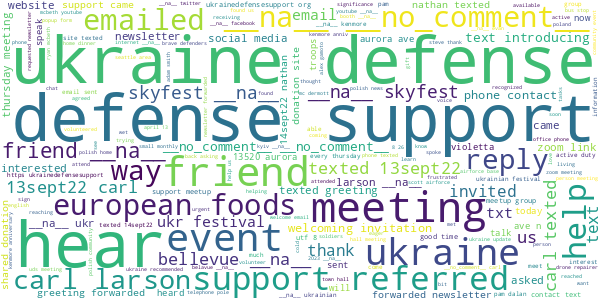

In [27]:
# Create a WordCloud object
wordcloud_raw = WordCloud(background_color="white", max_words=2000, include_numbers=True, collocation_threshold=5, width=600, height=300, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud_raw.generate(long_string_tidy)
# Visualize the word cloud
wordcloud_raw.to_image()

### 1.3 Real Vectorizing

### 1.3a `CountVectorizer()`
with trigrams

In [28]:
cv2 =  CountVectorizer(token_pattern='[a-zA-Z0-9_\$]+', ngram_range=(1,3)) 
cv2_fit = cv2.fit_transform(text_train) #class scipy.sparse._csr.csr_matrix
cv2_vocab = cv2.get_feature_names_out() #class numpy.ndarray
print("Vocab: ", len(cv2_vocab))
print("Preview vocab: ", cv2_vocab[:10])

cv2_fit.toarray().shape

Vocab:  6433
Preview vocab:  ['$100' '$100 because' '$100 because i' '$605' '1' '1 2022' '1 2022 every'
 '10' '10 boxes' '10 boxes of']


(326, 6433)

remove `stopwords`

In [29]:
cv3 =  CountVectorizer(token_pattern='[a-zA-Z0-9_\$]+', ngram_range=(1,3), stop_words='english') 
cv3_fit = cv3.fit_transform(text_train) #class scipy.sparse._csr.csr_matrix
cv3_vocab = cv3.get_feature_names_out() #class numpy.ndarray
print("Vocab: ", len(cv3_vocab))
print("Preview vocab: ", cv3_vocab[:10])
#print("cv3_fit:\n{}".format(repr(cv3_fit)))

cv3_fit.toarray().shape

Vocab:  3916
Preview vocab:  ['$100' '$100 just' '$100 just contact' '$605' '1' '1 2022' '1 2022 week'
 '10' '10 boxes' '10 boxes uniforms']


(326, 3916)

#### 1.3a.1 Diff between CVs trigrams  
removed `stopwords` vs not

In [30]:
#preview diff
np.setdiff1d(cv3_vocab, cv2_vocab), np.setdiff1d(cv2_vocab, cv3_vocab)

(array(['$100 just', '$100 just contact', '1 2022 week', ...,
        'zoom thursday meetings', 'zsu territorial',
        'zsu territorial defense'], dtype=object),
 array(['$100 because', '$100 because i', '1 2022 every', ..., 'zoom us j',
        'zsu and', 'zsu and other'], dtype=object))

In [31]:
cv2_count_list = cv2_fit.toarray().sum(axis=0)
cv2_vocab, cv2_count_list, cv2_count_list.sum()

(array(['$100', '$100 because', '$100 because i', ..., 'zsu', 'zsu and',
        'zsu and other'], dtype=object),
 array([1, 1, 1, ..., 1, 1, 1]),
 12113)

In [32]:
cv3_count_list = cv3_fit.toarray().sum(axis=0)
cv3_vocab, cv3_count_list, cv3_count_list.sum()

(array(['$100', '$100 just', '$100 just contact', ..., 'zsu',
        'zsu territorial', 'zsu territorial defense'], dtype=object),
 array([1, 1, 1, ..., 1, 1, 1]),
 6666)

### 1.3b `TfidfVectorizer()`

with trigrams

In [33]:
tfidf_v2 = TfidfVectorizer(token_pattern='[a-zA-Z0-9_\$]+', ngram_range=(1,3))
tfidf_v2_fit = tfidf_v2.fit_transform(text_train)
tfidf_v2_vocab = tfidf_v2.get_feature_names_out() #class numpy.ndarray
print("Vocab: ", len(tfidf_v2_vocab))
print("Preview vocab: ", tfidf_v2_vocab[:10])

tfidf_v2_fit.toarray().shape

Vocab:  6433
Preview vocab:  ['$100' '$100 because' '$100 because i' '$605' '1' '1 2022' '1 2022 every'
 '10' '10 boxes' '10 boxes of']


(326, 6433)

In [34]:
#confirm same n-grams
assert len(cv2_vocab) == len(tfidf_v2_vocab)

remove `stopwords`

In [35]:
tfidf_v3 = TfidfVectorizer(token_pattern='[a-zA-Z0-9_\$]+', ngram_range=(1, 3), stop_words="english")
tfidf_v3_fit = tfidf_v3.fit_transform(text_train)
tfidf_v3_vocab = tfidf_v3.get_feature_names_out() #class numpy.ndarray
print("Vocab: ", len(tfidf_v3_vocab))
print("Preview vocab: ", tfidf_v3_vocab[:10])

tfidf_v3_fit.toarray().shape

Vocab:  3916
Preview vocab:  ['$100' '$100 just' '$100 just contact' '$605' '1' '1 2022' '1 2022 week'
 '10' '10 boxes' '10 boxes uniforms']


(326, 3916)

In [36]:
#confirm same n-grams
assert len(cv3_vocab) == len(tfidf_v3_vocab)

#### 1.3b.1 Diff between TfidfVs trigrams  
removed `stopwords` vs not

In [37]:
#preview diff
np.setdiff1d(tfidf_v3_vocab, tfidf_v2_vocab), np.setdiff1d(tfidf_v2_vocab, tfidf_v3_vocab)

(array(['$100 just', '$100 just contact', '1 2022 week', ...,
        'zoom thursday meetings', 'zsu territorial',
        'zsu territorial defense'], dtype=object),
 array(['$100 because', '$100 because i', '1 2022 every', ..., 'zoom us j',
        'zsu and', 'zsu and other'], dtype=object))

In [38]:
tfidf_v2_count_list = tfidf_v2_fit.toarray().sum(axis=0)
tfidf_v2_vocab, tfidf_v2_count_list, tfidf_v2_count_list.sum()

(array(['$100', '$100 because', '$100 because i', ..., 'zsu', 'zsu and',
        'zsu and other'], dtype=object),
 array([0.02890545, 0.02890545, 0.02890545, ..., 0.02890545, 0.02890545,
        0.02890545]),
 1425.033233459337)

In [39]:
tfidf_v3_count_list = tfidf_v3_fit.toarray().sum(axis=0)
tfidf_v3_vocab, tfidf_v3_count_list, tfidf_v3_count_list.sum()

(array(['$100', '$100 just', '$100 just contact', ..., 'zsu',
        'zsu territorial', 'zsu territorial defense'], dtype=object),
 array([0.04116978, 0.04116978, 0.04116978, ..., 0.04116978, 0.04116978,
        0.04116978]),
 1119.4229362200674)

### 1.4 Final Vectorizer
with `min_df` or `max_df`?   
'min_df' gets rid of important tokens

In [40]:
tfidf_v4 = TfidfVectorizer(token_pattern='[a-zA-Z0-9_\$]+', ngram_range=(1, 3), stop_words="english", max_df = .1)
tfidf_v4_fit = tfidf_v4.fit_transform(text_train)
tfidf_v4_vocab = tfidf_v4.get_feature_names_out() #class numpy.ndarray
print("Vocab: ", len(tfidf_v4_vocab))
print("Preview vocab: ", tfidf_v4_vocab[:10])

tfidf_v4_fit.toarray().shape

Vocab:  3902
Preview vocab:  ['$100' '$100 just' '$100 just contact' '$605' '1' '1 2022' '1 2022 week'
 '10' '10 boxes' '10 boxes uniforms']


(326, 3902)

In [41]:
tfidf_v4_count_list = tfidf_v4_fit.toarray().sum(axis=0)
tfidf_v4_vocab, tfidf_v4_count_list, tfidf_v4_count_list.sum()

(array(['$100', '$100 just', '$100 just contact', ..., 'zsu',
        'zsu territorial', 'zsu territorial defense'], dtype=object),
 array([0.04123789, 0.04123789, 0.04123789, ..., 0.04123789, 0.04123789,
        0.04123789]),
 1029.8195606844124)

#### 1.4.1 Diff between TfidfVs trigrams  
with `max_df` vs not

In [42]:
#preview diff
np.setdiff1d(tfidf_v4_vocab, tfidf_v3_vocab), np.setdiff1d(tfidf_v3_vocab, tfidf_v4_vocab)


(array([], dtype=object),
 array(['__na__', 'defense', 'defense support', 'did', 'did hear',
        'did hear ukraine', 'hear', 'hear ukraine', 'hear ukraine defense',
        'meeting', 'support', 'ukraine', 'ukraine defense',
        'ukraine defense support'], dtype=object))

In [43]:
uds_stopwords = np.setdiff1d(tfidf_v3_vocab, tfidf_v4_vocab)

In [44]:
#save final vocab
try:
    with open('myData/my_vocab.csv', 'w', newline='', encoding='UTF-8') as myfile:
        wr = csv.writer(myfile, delimiter = '|')
        wr.writerows([r] for r in tfidf_v4_vocab)
except:
    print("An error occurred")
    for e in sys.exc_info():
        print("Error details: {}".format(str(e)))

- EDA Final Vectorizer - features

In [45]:
# find min and max features over dataset:
v_min = tfidf_v4_count_list.min()
v_max = tfidf_v4_count_list.max() 
print("Min {} and Max {} ".format(np.round(v_min, 4), v_max))

Min 0.0412 and Max 21.0 


In [46]:
idx_min = np.where(tfidf_v4_count_list == v_min)
idx_max = np.where(tfidf_v4_count_list == v_max)

print("Min feature(s): ", tfidf_v4_vocab[idx_min])
print("\nMax feature(s): ", tfidf_v4_vocab[idx_max])

Min feature(s):  ['$100' '$100 just' '$100 just contact' '10' '10 boxes'
 '10 boxes uniforms' '12345 sent' '12345 sent new' '12345 tap'
 '12345 tap mobile' '12532050468' '12532050468 9166147838'
 '12532050468 9166147838 12345' '614' '614 7838' '614 7838 passcode'
 '7838' '7838 passcode' '7838 passcode 12345' '916' '916 614'
 '916 614 7838' '9166147838 12345' '9166147838 12345 sent'
 '9166147838 pwd' '9166147838 pwd zkk1cg5nd01osm5bs0l3sfzac1bkqt09'
 'able arrange' 'able arrange delivery' 'active duty donations'
 'active duty musician' 'aid' 'aid poland' 'aid poland denton'
 'airforce base gathered' 'area 13520' 'area 13520 aurora' 'army'
 'army shipping' 'army shipping help' 'arrange' 'arrange delivery'
 'arrange delivery requesting' 'asked patty' 'asked patty murray'
 'asking donate' 'asking donate means' 'assistance' 'assistance program'
 'assistance program attach' 'attach' 'attach view' 'attach view seeing'
 'attend person' 'attend person zoom' 'ave n attend' 'background gave'
 'ba

In [47]:
tfidf_v4_fit.max(axis=0).toarray(), tfidf_v4_fit.toarray()

(array([[0.04123789, 0.04123789, 0.04123789, ..., 0.04123789, 0.04123789,
         0.04123789]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]))

In [48]:
# find maximum value for each of the features over dataset:
vals_max = tfidf_v4_fit.max(axis=0).toarray().ravel() #class numpy.ndarray
print("Max value shape:", vals_max.shape)

sorted_by_tfidf = vals_max.argsort()

print("Features with lowest tfidf:\n{}".format(tfidf_v4_vocab[sorted_by_tfidf[:20]]))

print("Features with highest tfidf: \n{}".format(tfidf_v4_vocab[sorted_by_tfidf[-20:]]))

sorted_by_idf = np.argsort(tfidf_v4.idf_)
print("Features with lowest idf:\n{}".format(tfidf_v4_vocab[sorted_by_idf[:20]]))

Max value shape: (3902,)
Features with lowest tfidf:
['zoom thursday' 'organization international'
 'organization international legion' 'organizations'
 'organizations probably' '614' '614 7838' '614 7838 passcode' '7838'
 '7838 passcode' '7838 passcode 12345' 'welcome zoom thursday' 'path'
 'path following' 'path following information' 'patty' 'patty murray'
 'patty murray help' 'pekerek' 'pekerek musician']
Features with highest tfidf: 
['meetup __na__' 'poster __na__' 'friend __na__' 'ukrainian __na__'
 'email __na__' 'carl __na__' '__no_comment__' 'emailed' 'craigslist'
 'txt' 'news' 'yes' 'poster' 'instagram' 'spouse' 'facebook'
 'participants' 'connected' 'flyer' 'friend']
Features with lowest idf:
['friend' 'texted' 'carl' 'event' '__no_comment__' 'email'
 'support referred' 'emailed' 'referred' 'support referred friend'
 'defense support referred' 'referred friend' 'text' 'support event'
 'defense support event' 'phone' 'came' 'newsletter' 'contact' 'help']


- EDA Final Vectorizer - w/ WordCloud

In [49]:
#Add extra stopwords in WordCloud?
# refer to https://stackoverflow.com/questions/53997443/how-to-add-extra-stop-words-in-addition-to-default-stopwords-in-wordcloud
my_stop_words = list(uds_stopwords) + list(text.ENGLISH_STOP_WORDS)
len(my_stop_words), len(uds_stopwords), len(text.ENGLISH_STOP_WORDS)

(332, 14, 318)

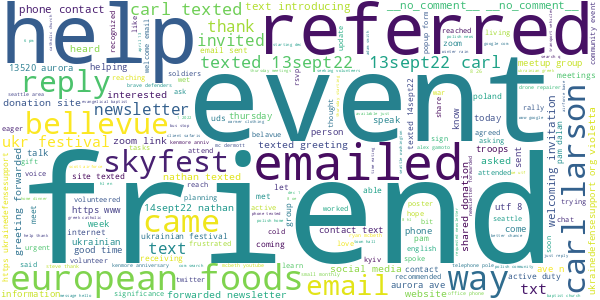

In [50]:
# Create a WordCloud object
wordcloud = WordCloud(stopwords = my_stop_words, background_color="white", max_words=2000, include_numbers=True, collocation_threshold=5, width=600, height=300, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

## Xtra

In [51]:
#$xtra 
#Python - sum of all counts in collections.Counter
# refer to https://testdriven.io/tips/6729e7af-9482-4b37-a780-fab42b709841/
from collections import Counter

pencil_stock = Counter({"Red": 17, "Blue": 5, "Green": 9}) #Counter for dicts

print(len(pencil_stock), pencil_stock.total())

3 31


In [52]:
mystop

NameError: name 'mystop' is not defined

# Xtra

#### Bag-of-Words
- Tokenize dataset and build the vocablulary  
- Revew vocabulary and features  
- Create bow representation of training data - SciPy sparse matrix
- dtm "dense" NumPy array to look at the actual content

In [ ]:
#$xtra 
#by default extracts tokens using a regex "\b\w\w+\b" - all sequences of chars that consist of at least two letters or numbers (\w) and that are separated by word boundaries(\b) => no single letter words, splits `don't` or `bit.ly`
vectorizer = CountVectorizer(min_df=0)

# `fit` to tokenize train data and build the vocabulary - <class 'dict'> {word,index}
vectorizer.fit(text_train.iloc[:10])

# access vocab with attribute vocabulary_ <class 'dict'>
print("Vocab size: {}".format(len(vectorizer.vocabulary_)))
print("Vocab (with word indices): {}".format(vectorizer.vocabulary_))

In [ ]:
#$xtra 
# get features
print("Vocab size:{}".format(len(vectorizer.get_feature_names())))
print("Vocab (ordered alphabetically): {}".format((vectorizer.get_feature_names())))

In [ ]:
#$xtra 
# `transform` to convert text to a bag of words
bow = vectorizer.transform(text_train.iloc[:10]) 
#SciPy sparse matrix only stores non-zero entries

print("Bag-of-words: {}".format(repr(bow)))

Manually get word frequencies

In [ ]:
#$xtra 
#10 records x 121 words
print (dtm.shape)

#each row=record, how many words each?
print(np.sum(dtm, axis=1))

#each column=word, frequency of each word?
print(np.sum(dtm, axis=0))

#confirm sums
np.sum(dtm, axis=1).sum(), np.sum(dtm, axis=0).sum()

In [ ]:
#$xtra save vocab base 
csv_columns = ['word','idx']
csv_file = "myExplore/vocab_ngrams3_index.csv"
try:
    with open(csv_file, 'w') as f:
        for key in vect_ngram.vocabulary_.keys():
            f.write("%s,%s\n"%(key,vect_ngram.vocabulary_[key]))
except IOError:
    print("I/O error")

In [ ]:
#$xtra WorldCloud
#  NOT Join tokens together.
#long_string = ','.join(list(text_train))
long_string = ','.join(tfidf_v4.vocabulary_)
len(long_string)

# Create a WordCloud object
wordcloud = WordCloud(stopwords = "english", background_color="white", max_words=2000, include_numbers=True, collocation_threshold=5, width=600, height=300, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

toGist $actodo

In [ ]:
#save vocab c1 
csv_columns = ['word','idx']
csv_file = "myExplore/vocab_base_index_tfidif_min001.csv"
try:
    with open(csv_file, 'w') as f:
        for key in vect_c2.vocabulary_.keys():
            f.write("%s,%s\n"%(key,vect_c2.vocabulary_[key]))
except IOError:
    print("I/O error")
